In [1]:
cd /Users/amandaash/Desktop/Research/scripts/

/Users/amandaash/Desktop/Research/scripts


In [39]:
from __future__ import print_function, division, absolute_import

import os

%matplotlib inline
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.io.ascii as at
import astropy.io.fits as fits
import astropy.units as u
from scipy.interpolate import interp1d
from cycler import cycler
import glob as glob
import spectra_functions
import pyspeckit
from PHEW import EqW as eqw
import pyspeckit as p
from scipy import stats
import csv
import statistics
import matplotlib.colors as colors

In [3]:
def findMiddle(input_list):
    middle = (len(input_list))/2
    if str(middle)[-1] == '0':
        return [input_list[int(middle)], input_list[int(middle-1)]]
    elif str(middle)[-1] == '5':
        return [input_list[int(middle - .5)]]

EPIC211928486 2017-11-28


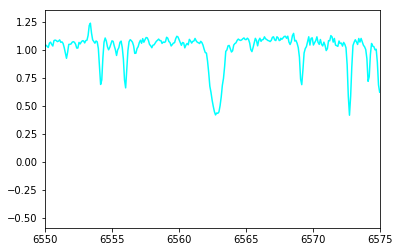

In [4]:
fname = '/Users/amandaash/Desktop/Research/data/Morris_targets/211928486/stack_EPIC211928486_2017-11-28.txt'
dat = np.genfromtxt(fname)
wave = dat[:,0]
flux = dat[:,1]
name = fname.split('/')[-1].split('_')[1]
date = fname.split('/')[-1].split('_')[-1].split('.')[0]

print(name, date)

plt.plot(wave,flux)
plt.xlim(6550,6575)
plt.show()

In [5]:
f_211928486 = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211928486/*.txt'))
for fname in f_211928486:
    name = 'EPIC 211928486'
    date = (fname.split('/')[8]).split('_')[2].split('.')[0]
    eperc = eqw.measure_equivalent_width_txt(str(fname),
                                     6560,6568,6561,6566,
                                     1000,xunit="Angstrom",to_plot=True,
                                     filebase="/Users/amandaash/Desktop/Research/plots/figures_morris/{0}_{1}.pdf".format(name,date))


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7044447234653685 0.02468524340608773
[0.67802478 0.7048574  0.72786515]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7085707759549864 0.022570523555654785
[0.68648657 0.70643171 0.73018409]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.8086401507342159 0.03572107763098692
[0.7737634  0.8093972  0.84441209]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.6454487931559526 0.021136943407091286
[0.62476582 0.64394114 0.66686636]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7094538150288379 0.021502697185832028
[0.6880579  0.70960132 0.73042306]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7214451868736702 0.025053093072352553
[0.69493998 0.72224331 0.74610526]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7052633744423203 0.01919921494916783
[0.68677886 0.70341985 0.7245783 ]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.722373570999133 0.027950621480671272
[0.69329113 0.72301976 0.75026105]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf


In [6]:
f_211966629 = sorted(glob.glob('/Users/amandaash/Desktop/Research/data/Morris_targets/211966629/*.txt'))
for fname in f_211966629:
    name = 'EPIC 211966629'
    date = (fname.split('/')[8]).split('_')[2].split('.')[0]
    eperc = eqw.measure_equivalent_width_txt(str(fname),
                                     6560,6568,6561,6566,
                                     1000,xunit="Angstrom",to_plot=True,
                                     filebase="/Users/amandaash/Desktop/Research/plots/figures_morris/{0}_{1}.pdf".format(name,date))


Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7800009009429942 0.03202640478977556
[0.74777502 0.7793192  0.81099668]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7675137635178162 0.02997676530702119
[0.7366748  0.76767046 0.79841647]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7444267896361612 0.025194419655149212
[0.71935734 0.74382303 0.77024397]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7388024282455965 0.02378592634718845
[0.71402574 0.73833382 0.76313168]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7948281972688233 0.028476449738517137
[0.76619249 0.79517123 0.82256401]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7431221357248154 0.028939279767935373
[0.71327245 0.7424397  0.77373018]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf
divide by zero encountered in true_divide

Legend.draggable() is drepecated in favor of Legend.set_draggable(). Legend.draggable may be reintroduced as a property in future releases.


0.7721837394086566 0.025949968789313632
[0.74597574 0.7717838  0.79741195]



The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
scipy.stats.norm.pdf
scipy.stats.norm.pdf


#use PHEW on each target exposure (this is antiquated)
EW = []
with open('/Users/amandaash/Desktop/Research/observation_info/EW.csv', 'r') as csvFile:
    EW_data = csv.reader(csvFile)
    for row in EW_data:
    
        EW.append(list(row))
csvFile.close()


import csv
import glob as glob
target_list = []
with open('/Users/amandaash/Desktop/Research/data/Target_names.csv', 'r') as csvFile:
    target_data = csv.reader(csvFile)
    for row in target_data:
        target_list.append(row[1])
csvFile.close()

targets = target_list[2:]

target_ex = ['A 575']

for target in target_ex:
    date_array = []
    EqW_array = []
    lower_error_array = []
    upper_error_array = []
    for n in EW[1:]:
        name = n[0]
        if name == target :
            date = int(n[1])
            if date == 20180111:
                date_array.append(1)
            if date == 20180112:
                date_array.append(2)
            if date == 20180113:
                date_array.append(3)
            if date == 20180114:
                date_array.append(4)
            if date == 20180115:
                date_array.append(5)
            if date == 20180116:
                date_array.append(6)
            if date == 20180117:
                date_array.append(7)
            if date == 20180118:
                date_array.append(8)
            if date == 20180119:
                date_array.append(9)
            if date == 20180120:
                date_array.append(10)
            if date == 20180121:
                date_array.append(11)
            if date == 20180122:
                date_array.append(12)
            if date == 20180123:
                date_array.append(13)
            if date == 20180124:
                date_array.append(14)
            if date == 20180125:
                date_array.append(15)
            if date == 20180126:
                date_array.append(16)
            if date == 20180127:
                date_array.append(17)
            if date == 20180128:
                date_array.append(18)
            if date == 20180129:
                date_array.append(19)
            if date == 20180130:
                date_array.append(20)
            if date == 20180131:
                date_array.append(21)
            if date == 20180201:
                date_array.append(22)
            if date == 20180202:
                date_array.append(23)
            if date == 20180203:
                date_array.append(24)
            if date == 20180204:
                date_array.append(25)
            if date == 20180205:
                date_array.append(26)
            if date == 20180206:
                date_array.append(27)
            if date == 20180207:
                date_array.append(28)
            if date == 20180208:
                date_array.append(29)
            if date == 20180209:
                date_array.append(30)
            EqW = float(n[2].split(' ')[1])
            #print(float(EqW))
            perc16 = float(n[2].split(' ')[0].split('[')[1])
            perc84 = float(n[2].split(' ')[2].split(']')[0])
            lower_uncertainty = EqW - perc16
            lower_error_array.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            upper_error_array.append(upper_uncertainty)
            EqW_array.append(EqW)
        else:
            continue
    
    plt.figure(figsize=(12,10))
    ax = plt.subplot(111)
    v = [lower_error_array, upper_error_array]
    days = np.arange(20180110,20180131,1)
    np.append(days, np.arange(20180200,20180209,1))
    #print(v.shape)
    ax.errorbar(date_array,EqW_array, yerr = v, fmt = 'o', color = 'b')
    #ax.plot(date_array,EqW_array, linestyle = 'dotted')
    ax.set_title(target, fontsize = 30)
    ax.set_ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    ax.set_xlabel('time (days)', fontsize = 26, labelpad = 24)
    ax.tick_params(labelsize = 24)
    #plt.savefig('/Users/amandaash/Desktop/Research/plots/EW_variability_61919/{0}_EW_variability.pdf'.format(target))
    plt.tight_layout()
    plt.show()


In [6]:
obs_info = []
with open('/Users/amandaash/Desktop/Research/observation_info/observation_table.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))

with open('/Users/amandaash/Desktop/Research/results/correlation_722_1.csv','w') as csvFile:
    row1 = ['litname', 'EPIC ID', 'spec type', 'P_rot', 'm_flux', 'r_flux', 'p_flux', 'std_flux', 'C_1', 'V_1', 
            'V_2', 'sigma V_2']
    wr = csv.writer(csvFile, dialect = 'excel')
    wr.writerow(row1)
csvFile.close()

for target in unique_target:
    EqW_array = []
    lower_error_array = []
    upper_error_array = []
    JD = []
    for n in obs_info[1:]:
        name = n[0]
        
        if name == target and n[12] == '0':
            UTC_date = n[5]
            UTC_time = n[6]       
            UTC = str(UTC_date)  + ' ' + str(UTC_time)     
            UTC_time= Time(UTC, scale = 'utc')
    
            JD_time = UTC_time.jd
            JD.append(JD_time)
            
            EqW = float(n[10])
            perc16 = float(n[9])
            perc84 = float(n[11])
            lower_uncertainty = EqW - perc16
            lower_error_array.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            upper_error_array.append(upper_uncertainty)
            EqW_array.append(EqW)
        
        else:
            continue
    
    if len(EqW_array) <= 2:
        continue
    
    plt.figure(figsize=(16,14))
    ax = plt.subplot(111)
    v = [lower_error_array, upper_error_array]
    days = np.arange(20180110,20180131,1)
    np.append(days, np.arange(20180200,20180209,1))
    #print(v.shape)
    ax.errorbar(JD,EqW_array, yerr = v, fmt = 'o', color = 'b')
    #ax.plot(date_array,EqW_array, linestyle = 'dotted')
    ax.set_ylim(np.max(EqW_array) + 3*np.std(EqW_array), np.min(EqW_array)-3*np.std(EqW_array))
    ax.set_title(target, fontsize = 30)
    ax.set_ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    ax.set_xlabel('time (days)', fontsize = 26, labelpad = 24)
    ax.tick_params(labelsize = 24)
    #plt.savefig('/Users/amandaash/Desktop/Research/plots/EW_variability_62319/{0}_EW_variability.pdf'.format(target))
    plt.tight_layout()
    plt.close()
    
    std_points = np.std(EqW_array)

    avg_errorbar_squared = []
    for bar in v:
        avg_sigma = (np.abs(bar[0]) + np.abs(bar[1]))/2
        avg_sigma_squared = avg_sigma**2
        avg_errorbar_squared.append(avg_sigma_squared)
    
    avg_sig_square = np.mean(avg_errorbar_squared)
    
    rms_sigma = np.sqrt(avg_sig_square)
    
    
    vary_stat = std_points/rms_sigma
    
    
    #R_EW
    
    max_EW = np.max(EqW_array)
    min_EW = np.min(EqW_array)
    med_EW = statistics.median(EqW_array)
    
    med_value = findMiddle(sorted(EqW_array))
    med_index = []
    
    
    for val in range(len(med_value)):
        ind = list(EqW_array).index(med_value[val])
        med_index.append(ind)
        
    stat2 = (min_EW - max_EW)/med_EW
    
    max_EW_index = np.where(EqW_array == max_EW)
    min_EW_index = np.where(EqW_array == min_EW)

    max_sigma = (np.abs(v[0][max_EW_index[0][0]])) + (np.abs(v[1][max_EW_index[0][0]]))/2
    min_sigma = (np.abs(v[0][min_EW_index[0][0]])) + (np.abs(v[1][min_EW_index[0][0]]))/2 
    
    if len(med_index) == 2:
        med_sigma = ((np.abs(v[0][med_index[0]]) + np.abs(v[1][med_index[0]])/2) + 
                     (np.abs(v[0][med_index[1]]) + np.abs(v[1][med_index[1]])/2))/2
    elif len(med_index) == 1:
        med_sigma = np.abs(v[0][med_index[0]]) + np.abs(v[1][med_index[0]])/2
    
    top = max_EW - min_EW
    top_sigma = np.sqrt(max_sigma**2 + min_sigma**2)
    
    sigma_stat2 = stat2*np.sqrt(((top_sigma/top)**2)+((med_sigma/med_EW)**2))
    
    stats_info = []

    with open('/Users/amandaash/Desktop/Research/results/correlation_718_2.csv','r') as csvFile:
        stats = csv.reader(csvFile)
        for row in stats:
            stats_info.append(row)

    
    for n in stats_info[1:]:
        if n[0] == target:
    
            with open('/Users/amandaash/Desktop/Research/results/correlation_722_1.csv','a') as csvFile:
                row = [n[0], n[1], n[2], n[3], n[4], n[5], n[6], n[7], n[8], vary_stat, top, top_sigma]
                wr = csv.writer(csvFile, dialect = 'excel')
                wr.writerow(row)
            csvFile.close()


In [7]:
from scipy import stats
obs_info = []
with open('/Users/amandaash/Desktop/Research/observation_info/observation_table.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])


with open('/Users/amandaash/Desktop/Research/results/correlation_722_2.csv','w') as csvFile:
    row1 = ['litname', 'EPIC ID', 'spec type', 'P_rot', 'm_flux', 'r_flux', 'p_flux', 'std_flux', 'C_flux', 'V_1', 
            'V_2', 'sigma V_2', 'm_secz', 'r_secz', 'p_secz',
            'std_secz', 'C_secz' ]
    wr = csv.writer(csvFile, dialect = 'excel')
    wr.writerow(row1)
csvFile.close()

corr_info = []

with open('/Users/amandaash/Desktop/Research/results/correlation_722_1.csv', 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for corr in corr_data:
        corr_info.append(corr)

    
unique_target = sorted(list(set(targets)))

for n in unique_target:
    secz_good = []
    EW_good = []
    EW_ue_good = []
    EW_le_good = []
    
    secz_bad = []
    EW_bad = []
    EW_ue_bad = []
    EW_le_bad = []
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[12]
        EPIC = row[1]
        if target_name == n and quality_flag == '0':
            sec = float(row[8])
            EqW = float(row[10])
            perc16 = float(row[9])
            perc84 = float(row[11])
            lower_uncertainty = EqW - perc16
            secz_good.append(sec)
            EW_le_good.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_good.append(upper_uncertainty)
            EW_good.append(EqW)
        if target_name == n and quality_flag == '2':
            sec = float(row[8])
            EqW = float(row[10])
            perc16 = float(row[9])
            perc84 = float(row[11])
            lower_uncertainty = EqW - perc16
            secz_bad.append(sec)
            EW_le_bad.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_bad.append(upper_uncertainty)
            EW_bad.append(EqW)

    if len(list(EW_good)) <= 2:
        continue
        
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(secz_good, EW_good)
    line = slope*np.array(secz_good) + intercept
    
    plt.figure(figsize=(16,14))    
    v_err_good = [EW_le_good, EW_ue_good]
    v_err_bad = [EW_le_bad, EW_ue_bad]
    plt.errorbar(secz_good, EW_good, yerr = v_err_good, fmt = 'o')
    plt.errorbar(secz_bad, EW_bad, yerr = v_err_bad, fmt = 'o', color = 'r')
    plt.plot(secz_good, line, color = 'k', linestyle = 'dashed')
    plt.ylim(np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good))
    plt.text(np.min(secz_good) + 0.01, np.max(EW_good) + np.std(EW_good),r'$m = $' + '%s' % float('%.6g' % slope), fontsize = 30)
    plt.text(np.min(secz_good) + 0.01, np.max(EW_good) + 2*np.std(EW_good),r'$\sigma = $' + '%s' % float('%.6g' % std_err), fontsize = 30)
    plt.title(n, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel('sec(z)', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.tight_layout()
    #plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/secz/{0}.pdf'.format(n))
    plt.close()
    
    
    for row in corr_info[1:]:
        target_name = row[0]
        if target_name == n:
            
            EPIC = row[1]
            spec_type = row[2]
            P_rot = row[3]
            m1 = row[4]
            r1 = row[5]
            p1 = row[6]
            std1 = row[7]
            mstd1 = float(row[8])
            std_rms = row[9]
            R_EW = row[10]
            R_EW_sigma = row[11]
            m2 = slope
            r2 = rvalue
            p2 = pvalue
            std2 = std_err
            mstd2 = slope/std_err
            
            corr_row = [target_name, EPIC, spec_type, P_rot, m1, r1, p1, std1, mstd1, std_rms, R_EW, R_EW_sigma, m2, r2, p1, std2, mstd2]
            
            with open('/Users/amandaash/Desktop/Research/results/correlation_722_2.csv','a') as csvFile:
                wr = csv.writer(csvFile, dialect = 'excel')
                wr.writerow(corr_row)
            csvFile.close()
            

In [8]:
obs_info = []
with open('/Users/amandaash/Desktop/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))

for target in unique_target:
    OI_shift_good = []
    EW_good = []
    EW_ue_good = []
    EW_le_good = []
    
    OI_shift_bad = []
    EW_bad = []
    EW_ue_bad = []
    EW_le_bad = []
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[13]
        if target_name == target and quality_flag == '0':
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift_good.append([OI])
            EW_le_good.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_good.append(upper_uncertainty)
            EW_good.append(EqW)
        if target_name == n and quality_flag == '2':
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift_bad.append(OI)
            EW_le_bad.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_bad.append(upper_uncertainty)
            EW_bad.append(EqW)

    if len(list(EW_good)) <= 2:
        continue
    
    plt.figure(figsize=(16,14))    
    v_err_good = [EW_le_good, EW_ue_good]    
    v_err_bad = [EW_le_bad, EW_ue_bad]
    plt.errorbar(OI_shift_good, EW_good, yerr = v_err_good, fmt = 'o')
    plt.errorbar(OI_shift_bad, EW_bad, yerr = v_err_bad, fmt = 'o', color = '#29088A')
    plt.ylim(np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good))
    plt.title(target, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel(r'OI shift', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.tight_layout()
    plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/OI_shift/{0}.pdf'.format(target))
    plt.close()
    
    

In [9]:
#OI with dates labled 
obs_info = []
with open('/Users/amandaash/Desktop/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))

for target in unique_target:
    OI_shift_good = []
    EW_good = []
    EW_ue_good = []
    EW_le_good = []
    date_good = []
    flag = []
    
    
    for row in obs_info[1:]:
        target_name = row[0]
        quality_flag = row[13]
        if target_name == target:
            date = row[4]
            OI = float(row[9])
            EqW = float(row[11])
            perc16 = float(row[10])
            perc84 = float(row[12])
            lower_uncertainty = EqW - perc16
            OI_shift_good.append([OI])
            EW_le_good.append(lower_uncertainty)
            upper_uncertainty = perc84 - EqW
            EW_ue_good.append(upper_uncertainty)
            EW_good.append(EqW)
            date_good.append(date)
            flag.append(quality_flag)

    if len(list(EW_good)) <= 2:
        continue
    custom_cycler = (cycler(color=['#81F781', '#01DF3A', '#298A08', '#A9F5D0', '#013ADF', '#D0A9F5', '#00BFFF', 
                                  '#120A2A', '#0489B1', '#DF01D7', '#A901DB', '#8A084B', '#088A4B', '#64FE2E', 
                                  '#F6CEEC', '#0A2A12', '#8000FF', '#F5DA81', '#F78181', '#A9A9F5', '#CEE3F6', 
                                  '#01A9DB', '#8258FA', '#D8D8D8', '#A4A4A4', '#6E6E6E', '#2E2E2E', '#2E2E2E', 
                                  '#9AFE2E', '#0B3B2E', '#071019', '#0B0B3B', '#F8E0E6', '#3A01DF', '#1B2A0A', 
                                   '#DBA901', '#4000FF']))
    
    plt.figure(figsize=(16,14))
    plt.rc('axes', prop_cycle=custom_cycler)
    v_err_good = [EW_le_good, EW_ue_good]    
    v_err_bad = [EW_le_bad, EW_ue_bad]
    data_good = np.column_stack((OI_shift_good, EW_good, EW_le_good, EW_ue_good, date_good, flag))
    #data_bad = np.column_stack((OI_shift_bad, EW_bad, EW_le_bad, EW_ue_bad, date_bad))
    for data_pt in data_good:
        if data_pt[5] == '0':
            plt.errorbar(float(data_pt[0]), float(data_pt[1]), yerr = [[float(data_pt[2])], [float(data_pt[3])]], label = data_pt[4] + ': good', fmt = 'o')
            plt.text(float(data_pt[0]), float(data_pt[1]),data_pt[4],  size = 'small')
        if data_pt[5] == '2':
    #for data_pt in data_bad:
            plt.errorbar(float(data_pt[0]), float(data_pt[1]), yerr = [[float(data_pt[2])], [float(data_pt[3])]], label = data_pt[4] + ': bad', fmt = 'o')
            plt.text(float(data_pt[0]), float(data_pt[1]),data_pt[4],  size = 'small')
    #plt.errorbar(OI_shift_good, EW_good, yerr = v_err_good, fmt = 'o')
    #plt.errorbar(OI_shift_bad, EW_bad, yerr = v_err_bad, fmt = 'o', color = '#29088A')
    #plt.ylim(np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good))
    plt.title(target, fontsize = 30)
    plt.ylabel(r'$H_{\alpha}\ EW\ (\AA)$', fontsize = 26, labelpad = 24)
    plt.xlabel(r'OI shift', fontsize = 26, labelpad = 24)
    plt.tick_params(labelsize = 24)
    plt.vlines([3, -3], np.max(EW_good) + 3*np.std(EW_good), np.min(EW_good)-3*np.std(EW_good), linestyle = 'dashed')
    plt.legend()
    plt.tight_layout()
    plt.savefig('/Users/amandaash/Desktop/Research/plots/obs_analysis/OI_shift/labeled_exposures/{0}.pdf'.format(target))
    plt.close()
    
    

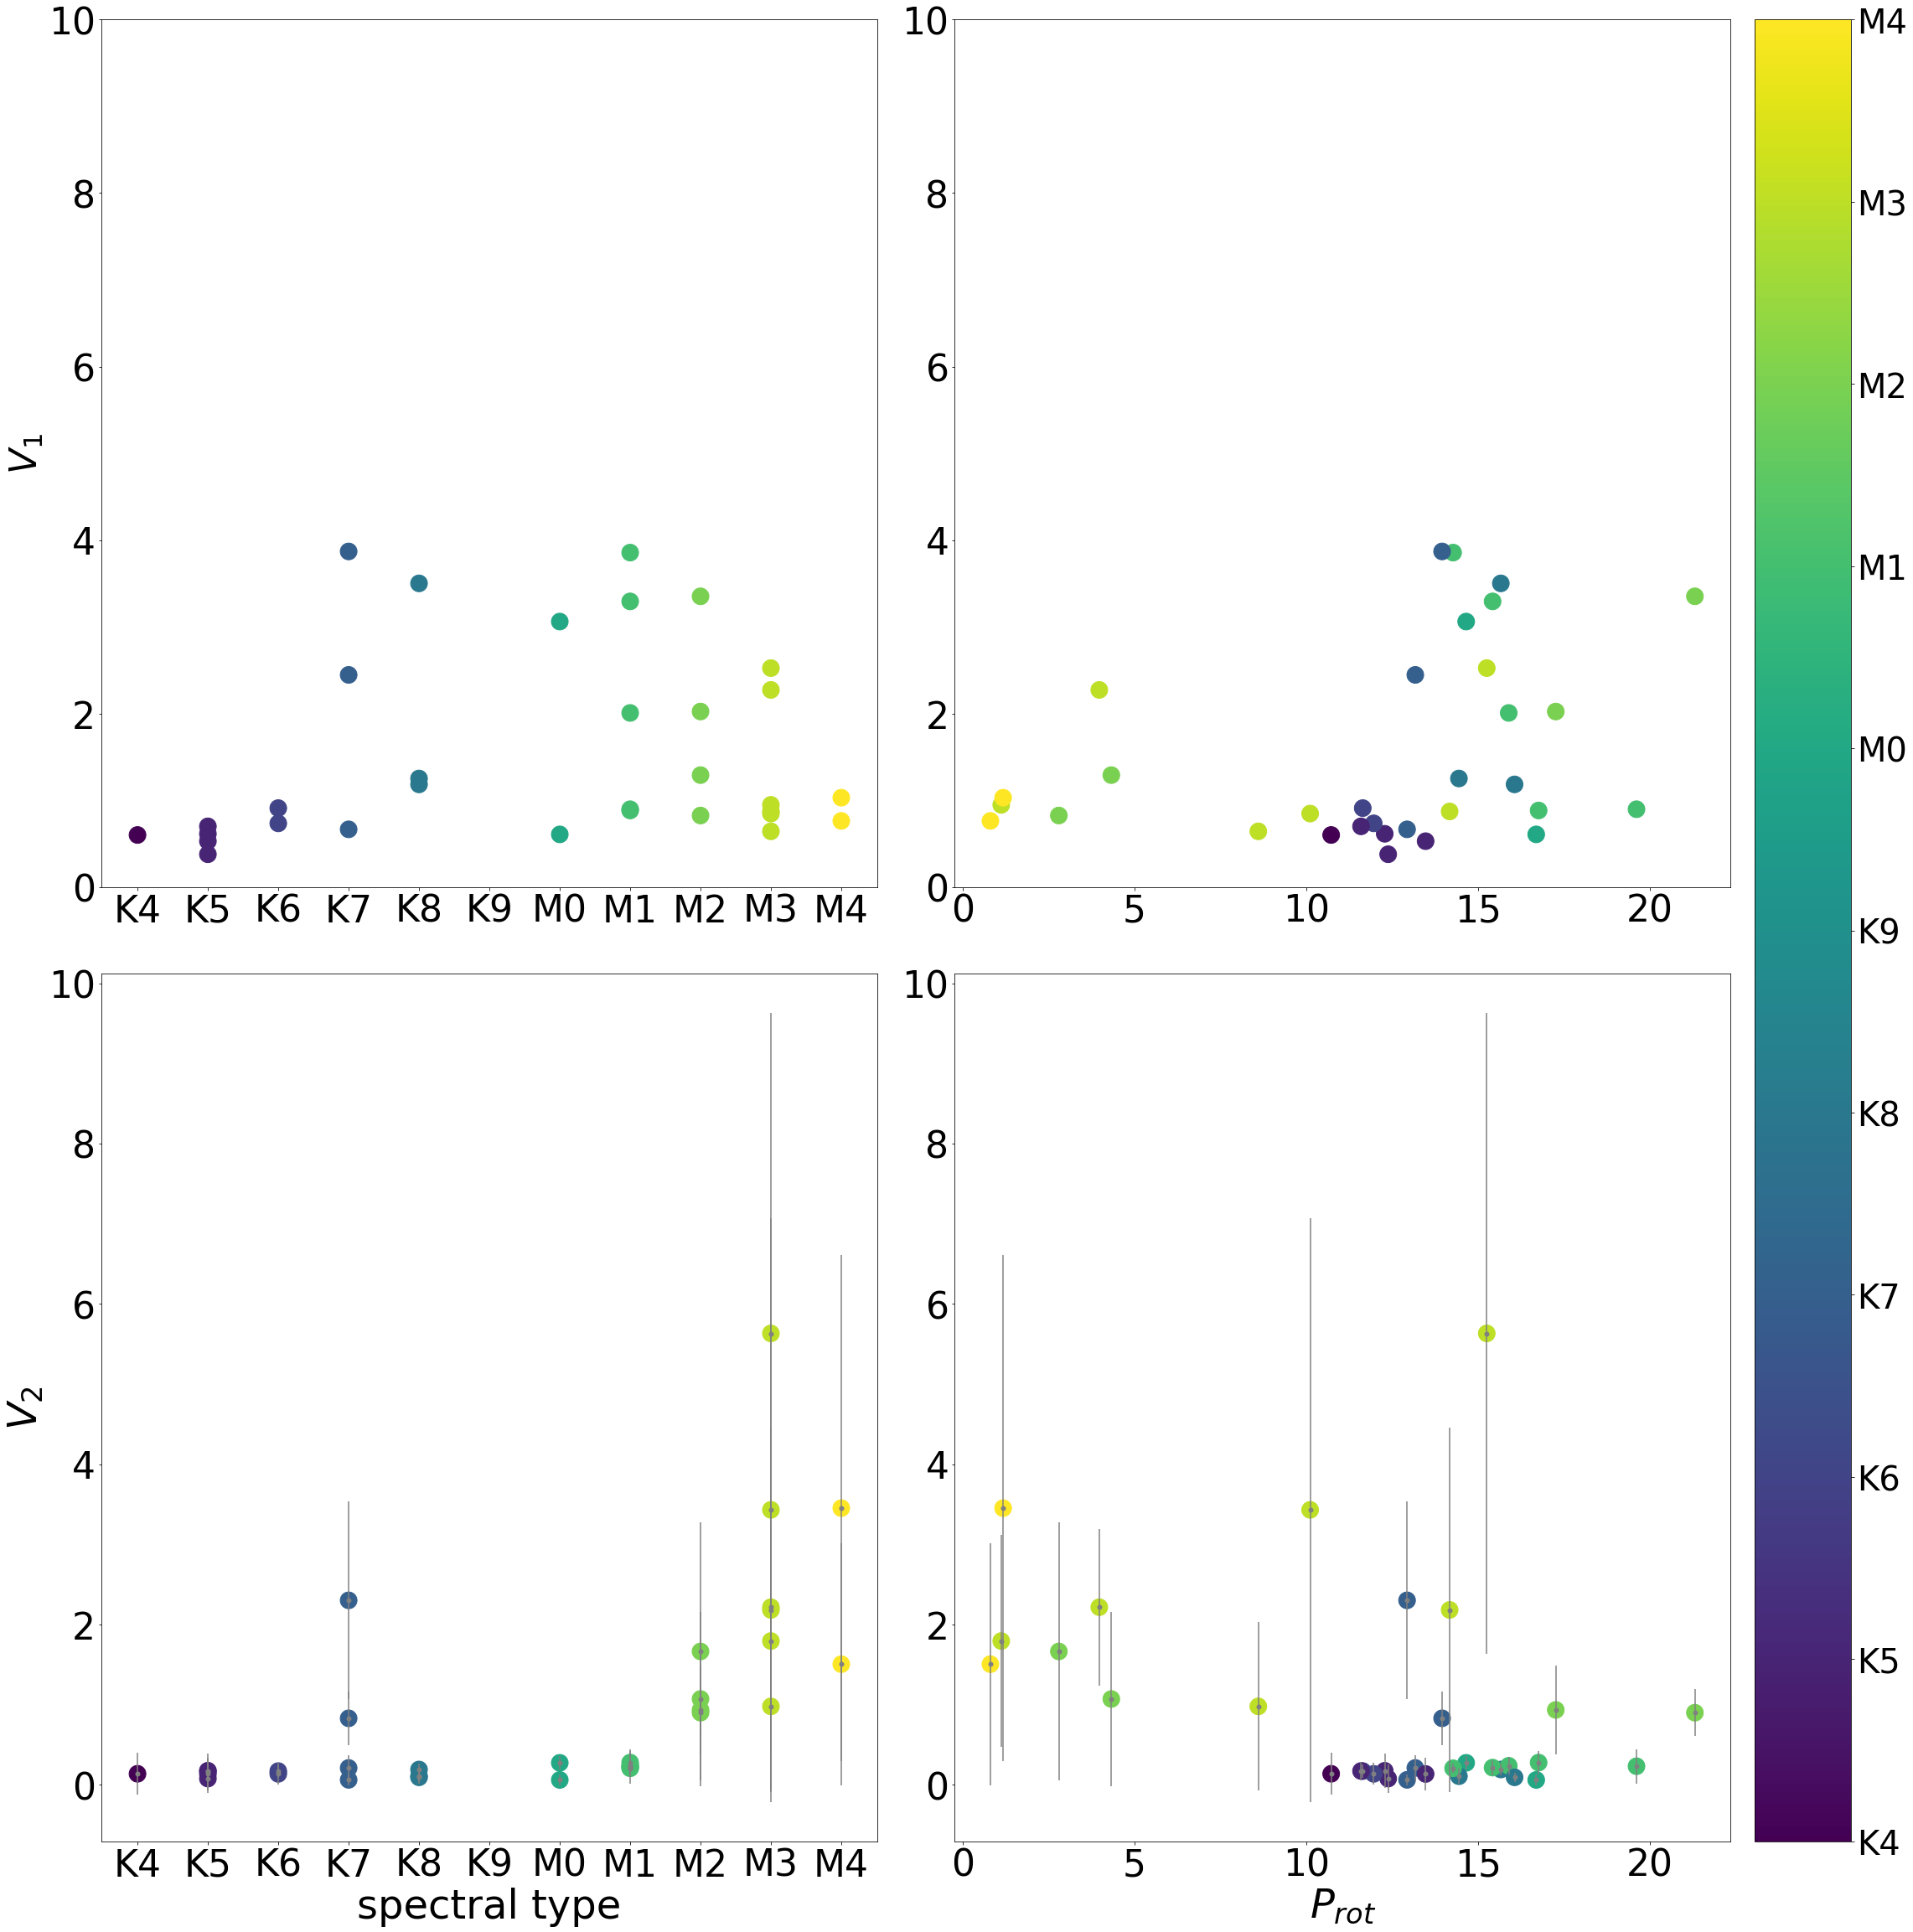

In [33]:
#variability vs. spec.type
corr_info = []
with open('/Users/amandaash/Desktop/Research/results/correlation_722_2.csv', 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

spec = []
Prot = []
vary_stat1 = []
vary_stat2 = []
vary_stat2_err = []


for row in corr_info[1:]:
    spec.append(row[2])
    Prot.append(float(row[3]))
    vary_stat1.append(float(row[9]))
    vary_stat2.append(float(row[10]))
    vary_stat2_err.append(float(row[11]))
    
    
spec_labels = ['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4']

spec_plot = []

for n in spec:
    if n == 'K4':
        spec_plot.append(1)
    if n == 'K5':
        spec_plot.append(2)
    if n == 'K6':
        spec_plot.append(3)
    if n == 'K7':
        spec_plot.append(4)
    if n == 'K8':
        spec_plot.append(5)
    if n == 'K9':
        spec_plot.append(6)
    if n == 'M0':
        spec_plot.append(7)
    if n == 'M1':
        spec_plot.append(8)
    if n == 'M2':
        spec_plot.append(9)
    if n == 'M3':
        spec_plot.append(10)
    if n == 'M4':
        spec_plot.append(11)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40,40))
scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":.5, "zorder":0}
plt.subplots_adjust()
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sv1 = ax1.scatter(spec_plot, vary_stat1, s = 400, c = spec_plot, cmap='viridis')
ax1.set_xticks(ticks = np.arange(1,12,1))
ax1.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax1.set_xlabel(r'spectral type', fontsize = 48)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
ax1.set_ylim(0,10)


ax2.scatter(Prot, vary_stat1, s = 400, c = spec_plot, cmap='viridis')
#ax2.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax2.set_ylabel(r'$\frac{std(EW \ H\alpha)}{rms(EW \sigma)}$', fontsize = 44)
ax2.set_ylim(0,10)

sv2 = ax3.scatter(spec_plot, vary_stat2, s = 400, c = spec_plot, cmap='viridis')
ax3.errorbar(spec_plot, vary_stat2, yerr = vary_stat2_err, fmt = 'o', markersize=None, color = 'grey', mew=0)
ax3.set_xticks(ticks = np.arange(1,12,1))
ax3.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
ax3.set_xlabel(r'spectral type', fontsize = 48)
ax3.set_ylabel(r'$V_2$', fontsize = 48)
#ax3.set_ylim(0,10)




ax4.scatter(Prot, vary_stat2, c = spec_plot, s = 400)
ax4.errorbar(Prot, vary_stat2, yerr = vary_stat2_err, fmt = 'o', markersize=None, color = 'grey', mew=0)
ax4.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax4.set_ylabel(r'$R_{EW}$', fontsize = 48)
#ax4.set_ylim(-5,5)


cbar_ax = fig.add_axes([0.81, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)

fig.savefig('/Users/amandaash/Desktop/variance_metrics.pdf')
plt.show()



In [42]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

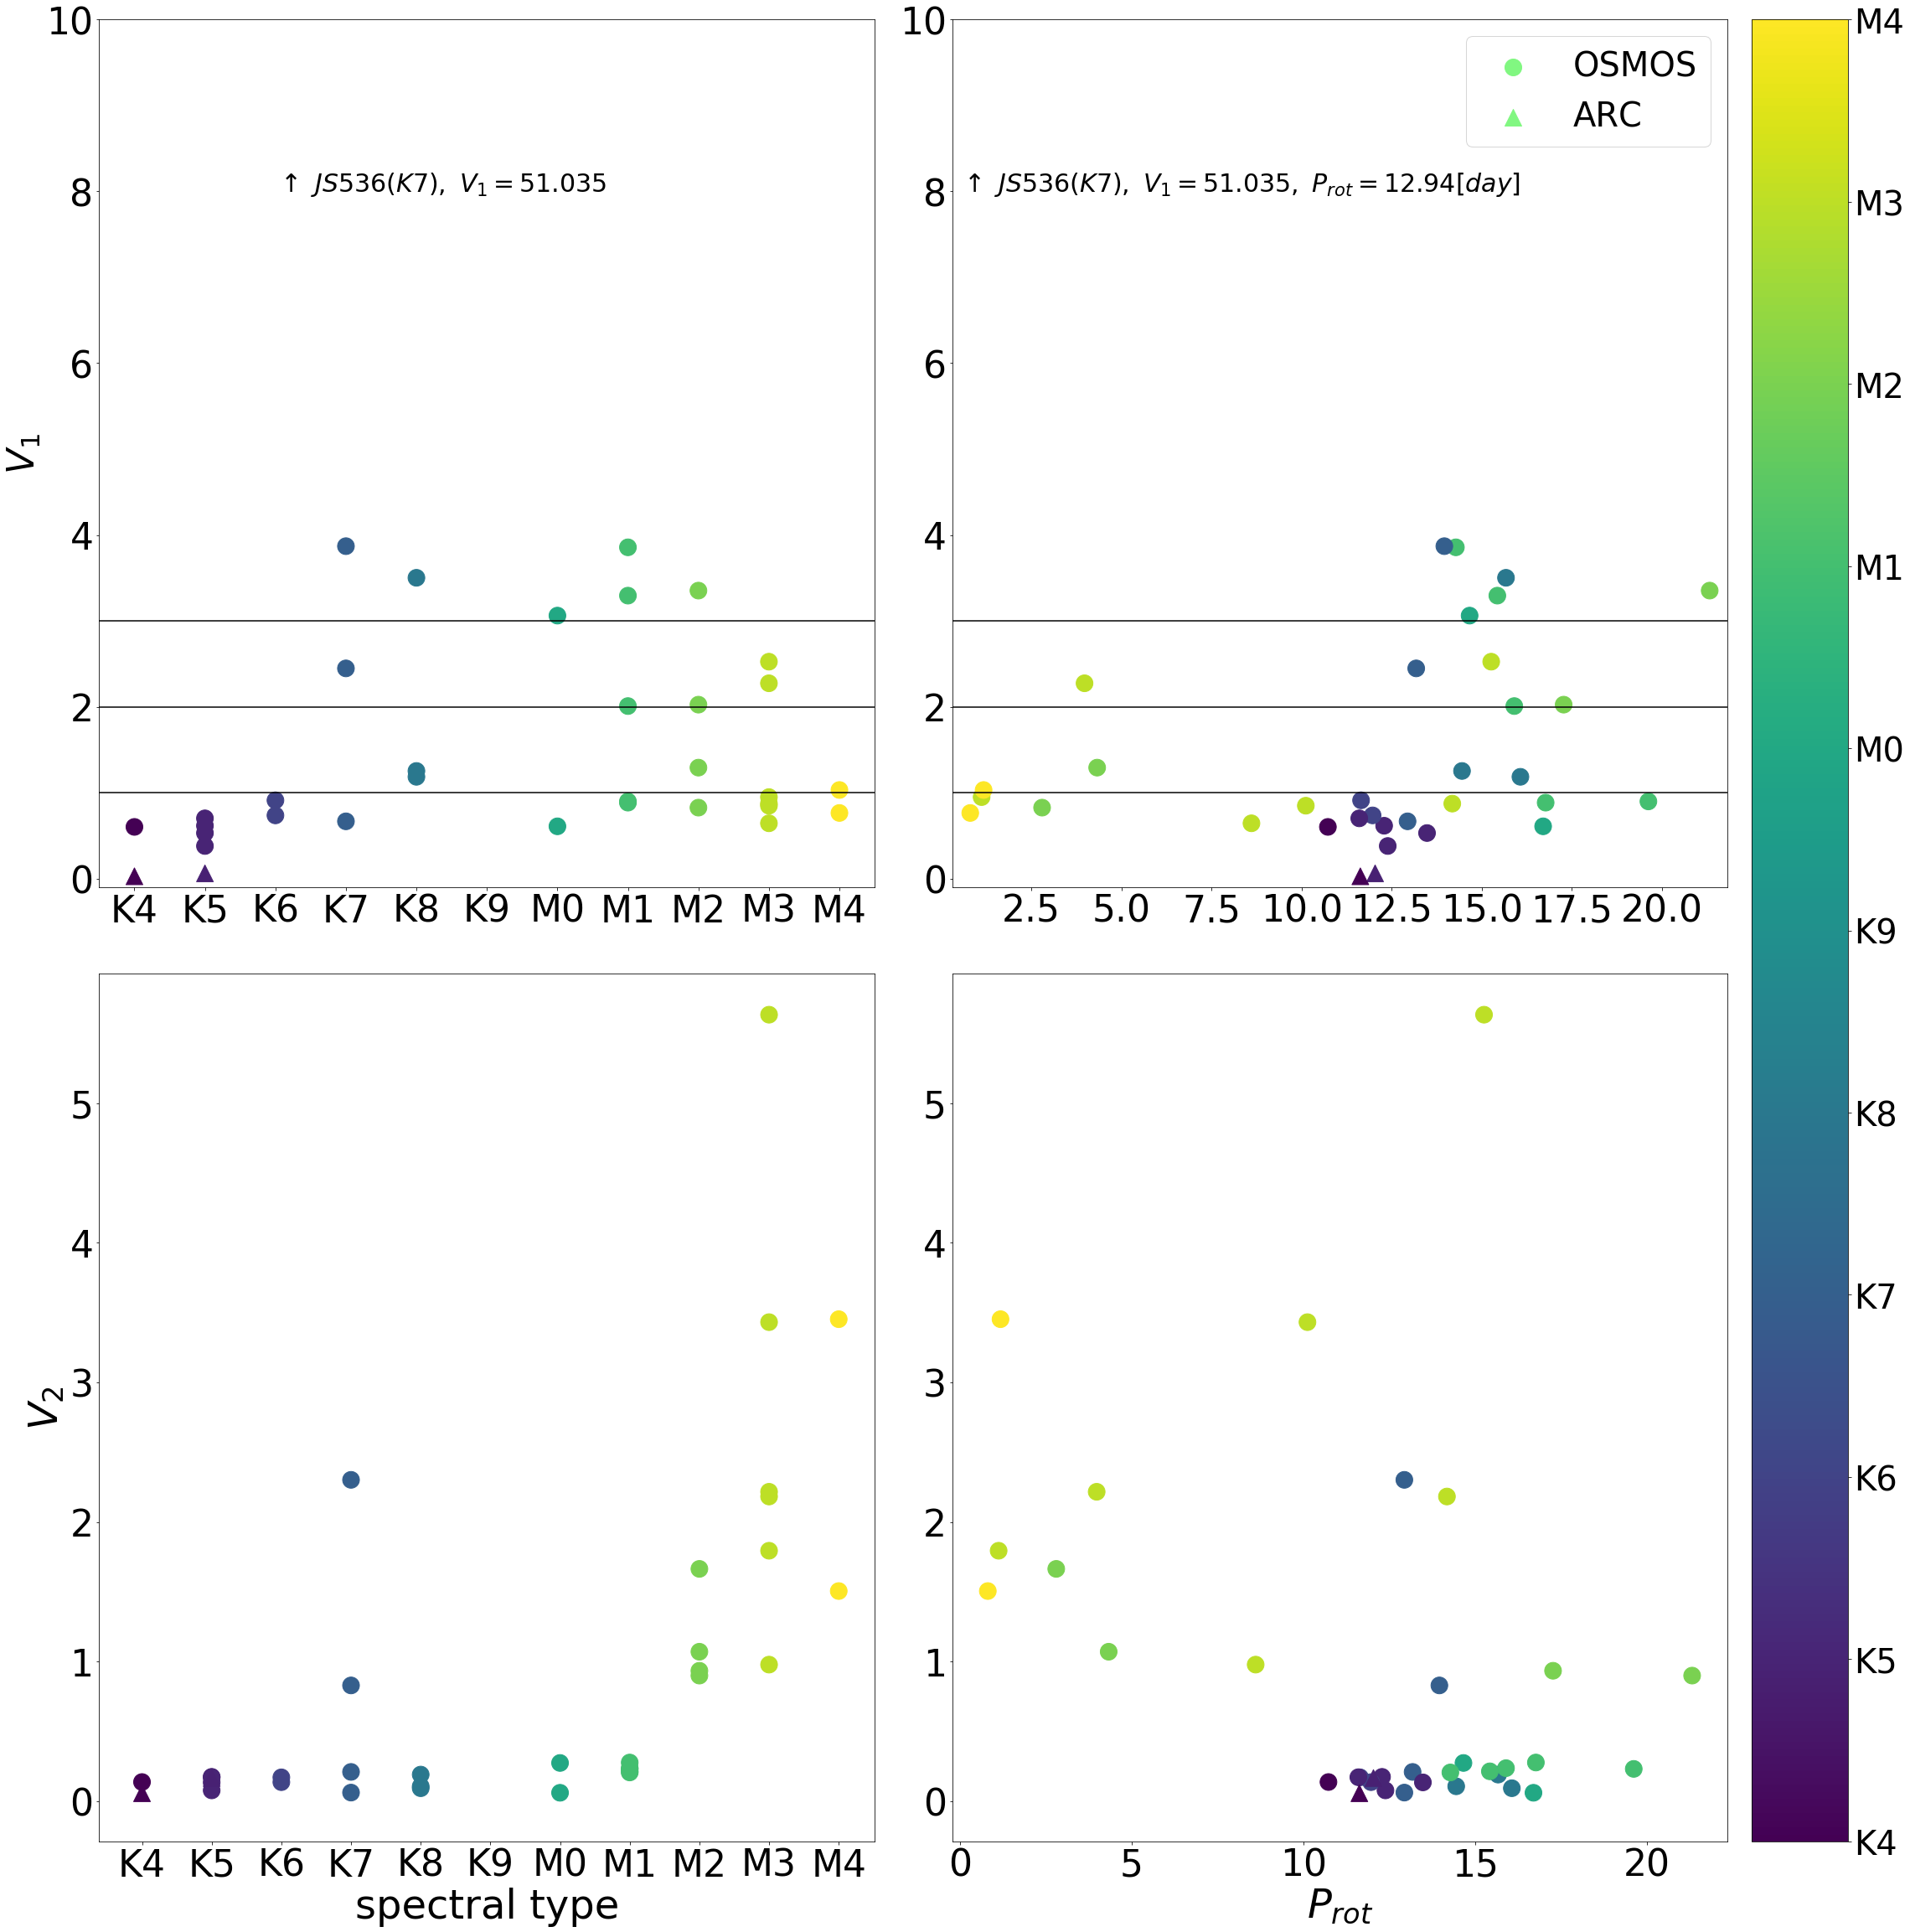

In [109]:
#adding in Morris targets to look at variance:

morris = []
with open('/Users/amandaash/Desktop/morris_obs_tab.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
          morris.append(row)
csvFile.close()

JS482_EW = []
JS482_l_err = []
JS482_u_err = []

JS566_EW = []
JS566_l_err = []
JS566_u_err = []

for line in morris:
    if line[0] == 'JS482':
        JS482_EW.append(float(line[6]))
        JS482_l_err.append(float(line[5]))
        JS482_u_err.append(float(line[7]))
    if line[0] == 'JS566':
        JS566_EW.append(float(line[6]))
        JS566_l_err.append(float(line[5]))
        JS566_u_err.append(float(line[7]))

        
std_points_482 = np.std(JS482_EW)
std_points_566 = np.std(JS566_EW)

JS482_v = [JS482_l_err, JS482_u_err]
JS566_v = [JS566_l_err, JS566_u_err]

avg_errorbar_squared_482 = []
avg_errorbar_squared_566 = []
for bar in JS482_v:
    avg_sigma = (np.abs(bar[0]) + np.abs(bar[1]))/2
    avg_sigma_squared = avg_sigma**2
    avg_errorbar_squared_482.append(avg_sigma_squared)

for bar in JS566_v:
    avg_sigma = (np.abs(bar[0]) + np.abs(bar[1]))/2
    avg_sigma_squared = avg_sigma**2
    avg_errorbar_squared_566.append(avg_sigma_squared)


    
avg_sig_square_482 = np.mean(avg_errorbar_squared_482)
rms_sigma_482 = np.sqrt(avg_sig_square_482)
v1_482 = std_points_482/rms_sigma_482

avg_sig_square_566 = np.mean(avg_errorbar_squared_566)
rms_sigma_566 = np.sqrt(avg_sig_square_566)
v1_566 = std_points_566/rms_sigma_566

v2_482 = np.max(JS482_EW)-np.min(JS482_EW)
v2_566 = np.max(JS566_EW)-np.min(JS566_EW)

max_EW_index_482 = np.where(JS482_EW == np.max(JS482_EW))
min_EW_index_482 = np.where(JS482_EW == np.min(JS482_EW))
max_sigma_482 = (np.abs(JS482_v[0][max_EW_index_482[0][0]])) + (np.abs(JS482_v[1][max_EW_index_482[0][0]]))/2
min_sigma_482 = (np.abs(JS482_v[0][min_EW_index_482[0][0]])) + (np.abs(JS482_v[1][min_EW_index_482[0][0]]))/2 

max_EW_index_566 = np.where(JS566_EW == np.max(JS566_EW))
min_EW_index_566 = np.where(JS566_EW == np.min(JS566_EW))
max_sigma_566 = (np.abs(JS566_v[0][max_EW_index_566[0][0]])) + (np.abs(JS566_v[1][max_EW_index_566[0][0]]))/2
min_sigma_566 = (np.abs(JS566_v[0][min_EW_index_566[0][0]])) + (np.abs(JS566_v[1][min_EW_index_566[0][0]]))/2 

v2_sigma_482 = np.sqrt((max_sigma_482**2)+(min_sigma_482**2))
v2_sigma_566 = np.sqrt((max_sigma_566**2)+(min_sigma_566**2))

v1_morris = [v1_482,v1_566]
v2_morris = [v2_482,v2_566]
v2_err_morris = [v2_sigma_482,v2_sigma_566]
spec_morris = ['K5', 'K4']
spec_plot_morris = [2,1]
Prot_morris = [12.04,11.63]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(40,40))
scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":.5, "zorder":0}
plt.subplots_adjust()
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

cmap_ARC = truncate_colormap(plt.get_cmap('viridis'), 0, 0.09090909090909091)

sv1 = ax1.scatter(spec_plot, vary_stat1, s = 400, c = spec_plot, cmap='viridis', label = 'OSMOS')
ax1.scatter(spec_plot_morris,v1_morris,s = 400, c=spec_plot_morris,cmap = cmap_ARC,marker='^',label = 'ARC')
ax1.set_xticks(ticks = np.arange(1,12,1))
ax1.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax1.set_xlabel(r'spectral type', fontsize = 48)
ax1.hlines([1,2,3], xmin = np.min(spec_plot)-1, xmax=np.max(spec_plot)+1)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
ax1.set_ylim(-0.1,10)
ax1.set_xlim(np.min(spec_plot)-0.5, np.max(spec_plot)+0.5)
ax1.text(3,8,r'$\uparrow \ JS536(K7), \ V_1=51.035$', fontsize = 30)

ax2.scatter(Prot, vary_stat1, s = 400, c = spec_plot, cmap='viridis',label = 'OSMOS')
ax2.scatter(Prot_morris,v1_morris, s = 400,c = spec_plot_morris, cmap = cmap_ARC, label = 'ARC', marker = '^')
#ax2.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax2.set_ylabel(r'$\frac{std(EW \ H\alpha)}{rms(EW \sigma)}$', fontsize = 44)
ax2.hlines([1,2,3], xmin = np.min(Prot)-1, xmax=np.max(Prot)+1)
ax2.set_ylim(-0.1,10)
ax2.legend(prop={'size': 40})
ax2.set_xlim(np.min(Prot)-0.5, np.max(Prot)+0.5)
ax2.text(0.5,8,r'$\uparrow \ JS536(K7), \ V_1=51.035, \ P_{rot}=12.94[day]$', fontsize = 30)


sv2 = ax3.scatter(spec_plot, vary_stat2, s = 400, c = spec_plot, cmap='viridis', label = 'OSMOS')
ax3.scatter(spec_plot_morris,v2_morris,s = 400, c = spec_plot_morris, cmap = cmap_ARC, marker = '^', label = 'ARC')
#ax3.errorbar(spec_plot, vary_stat2, yerr = vary_stat2_err, fmt = 'o', markersize=None, color = 'grey', mew=0)
#ax3.errorbar(spec_plot_morris, v2_morris, yerr = v2_err_morris,fmt = '^', markersize=None, color = 'grey', mew = 0)
ax3.set_xticks(ticks = np.arange(1,12,1))
ax3.set_xticklabels(labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'))
for tick in ax3.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax3.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
ax3.set_xlabel(r'spectral type', fontsize = 48)
ax3.set_ylabel(r'$V_2$', fontsize = 48)
#ax3.set_ylim(0,10)




ax4.scatter(Prot, vary_stat2, c = spec_plot, s = 400, cmap='viridis', label = 'OSMOS')
ax4.scatter(Prot_morris,v2_morris,c=spec_plot_morris,s = 400, cmap = cmap_ARC, marker = '^', label = 'ARC')
#ax4.errorbar(Prot, vary_stat2, yerr = vary_stat2_err, fmt = 'o', markersize=None, color = 'grey', mew=0)
#ax4.errorbar(Prot_morris, v2_morris, fmt = '^', markersize = None, color = 'grey', mew = 0)
ax4.set_xlabel(r'$P_{rot}$', fontsize = 48)
for tick in ax4.xaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
for tick in ax4.yaxis.get_major_ticks():
    tick.label.set_fontsize(44) 
#ax4.set_ylabel(r'$R_{EW}$', fontsize = 48)
#ax4.set_ylim(-5,5)


cbar_ax = fig.add_axes([0.81, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)

fig.savefig('/Users/amandaash/Desktop/variance_metrics_OSMOSARC.pdf')
plt.show()

with open('/Users/amandaash/Desktop/morris_correlation1.csv', 'w') as csvF:
    row = ['litname', 'EPIC ID', 'spec type', 'P_rot', 'm', 'r', 'p', 'std', 'm/std', 'V1', 'V2', 'V2_err']
    wr = csv.writer(csvF, dialect = 'excel')
    wr.writerow(row)
csvF.close()

morris_corr = []
with open('/Users/amandaash/Desktop/morris_correlation.csv', 'r') as csvFile:
    corr = csv.reader(csvFile)
    for row in corr:
          morris_corr.append(row)
csvFile.close()

morris_corr = morris_corr[1:]

corr_row1 = [morris_corr[0][0], morris_corr[0][1], morris_corr[0][2], morris_corr[0][3], morris_corr[0][4], morris_corr[0][5], 
             morris_corr[0][6], morris_corr[0][7], morris_corr[0][8], v1_morris[0], v2_morris[0], v2_err_morris[0]]
corr_row2 = [morris_corr[1][0], morris_corr[1][1], morris_corr[1][2], morris_corr[1][3], morris_corr[1][4], morris_corr[1][5], 
             morris_corr[1][6], morris_corr[1][7], morris_corr[1][8], v1_morris[1], v2_morris[1], v2_err_morris[1]]

with open('/Users/amandaash/Desktop/morris_correlation1.csv', 'a') as csvF:
    wr = csv.writer(csvF, dialect = 'excel')
    wr.writerow(corr_row1)
    wr.writerow(corr_row2)
csvF.close()


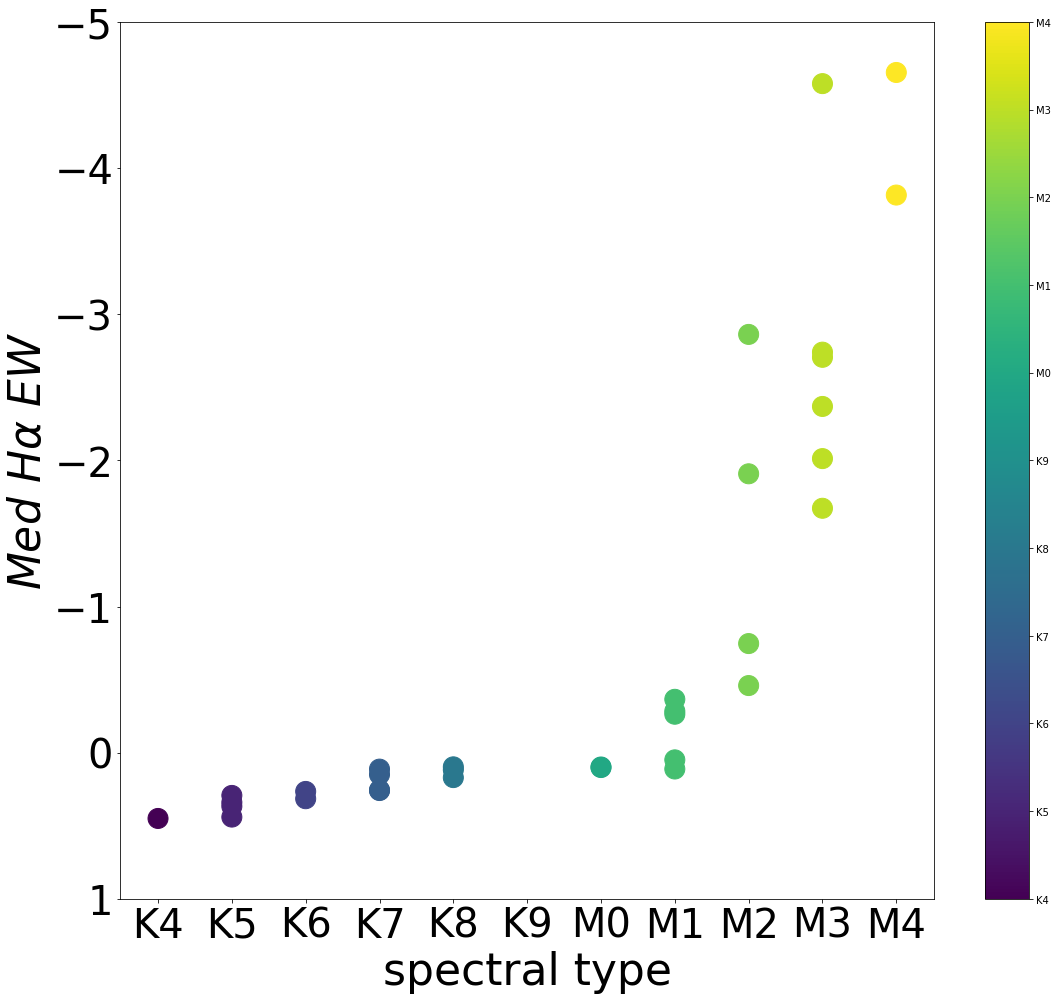

In [111]:
import csv
import glob as glob
obs_info = []
with open('/Users/amandaash/Desktop/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

import csv
corr_info = []
with open('/Users/amandaash/Desktop/Research/results/correlation_722_2.csv', 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))
med_EW = []
spec = []

good_target = []

for target in unique_target:
    if target == 'JS414':
        continue
    if target ==  'JS488':
        continue
    else:
        good_target.append(target)

for obj in good_target:    
    EW = []
    for row in obs_info[1:]:
        target_name = row[0]
        if target_name == obj:
             EW.append(float(row[11]))
    med_EW.append(np.median(EW))



spec = []
for target in good_target:
    for row in corr_info[1:]:
        target_name = row[0]
        if target_name == 'A 575':
            name = 'A575'
        elif target_name == 'AD 2642':
            name = 'AD2642'
        elif target_name == 'AD 4269':
            name = 'AD4269'
        else:
            name = target_name
            
        if name == target:
    
            spec_type = row[2]
            spec.append(spec_type)
    
spec_labels = ['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4']

spec_plot = []

for n in spec:
    if n == 'K4':
        spec_plot.append(1)
    if n == 'K5':
        spec_plot.append(2)
    if n == 'K6':
        spec_plot.append(3)
    if n == 'K7':
        spec_plot.append(4)
    if n == 'K8':
        spec_plot.append(5)
    if n == 'K9':
        spec_plot.append(6)
    if n == 'M0':
        spec_plot.append(7)
    if n == 'M1':
        spec_plot.append(8)
    if n == 'M2':
        spec_plot.append(9)
    if n == 'M3':
        spec_plot.append(10)
    if n == 'M4':
        spec_plot.append(11)


plt.figure(figsize=(16,14))
plt.scatter(spec_plot, med_EW, s = 400, c = spec_plot)
plt.xlabel(r'spectral type', fontsize = 44)
plt.ylabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
plt.xticks(ticks = np.arange(1,12,1), labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'), fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylim(1,-5)
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'])
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/activityvspec.pdf')
plt.show()

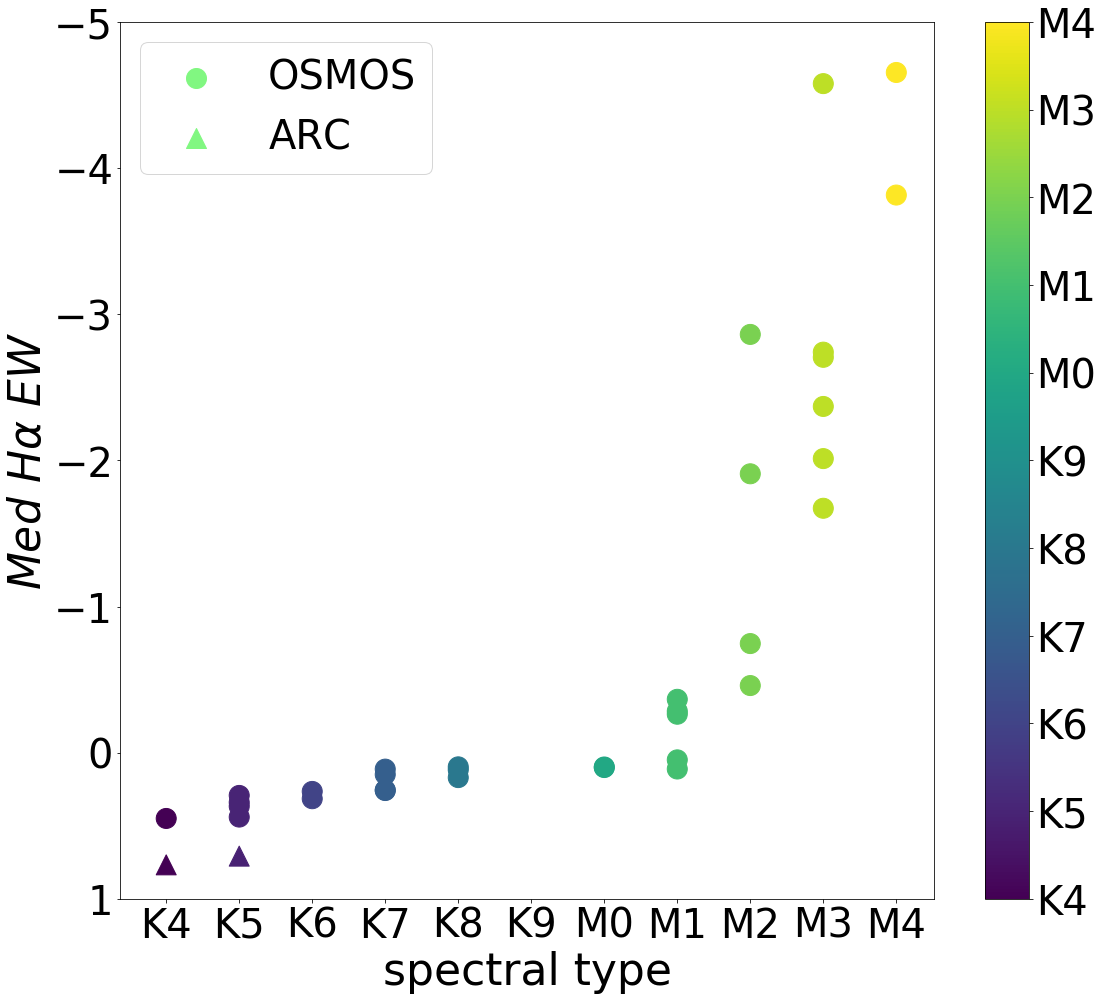

In [87]:
obs_info = []
with open('/Users/amandaash/Desktop/obs_table_715_update.csv', 'r') as csvFile:
    obs_data = csv.reader(csvFile)
    for row in obs_data:
    
        obs_info.append(list(row))
csvFile.close()

import csv
corr_info = []
with open('/Users/amandaash/Desktop/Research/results/correlation_722_2.csv', 'r') as csvFile:
    corr_data = csv.reader(csvFile)
    for row in corr_data:
        corr_info.append(list(row))
csvFile.close()

targets = []

for row in obs_info[1:]:
    targets.append(row[0])

    
unique_target = sorted(list(set(targets)))
med_EW = []
spec = []

good_target = []

for target in unique_target:
    if target == 'JS414':
        continue
    if target ==  'JS488':
        continue
    else:
        good_target.append(target)

for obj in good_target:    
    EW = []
    for row in obs_info[1:]:
        target_name = row[0]
        if target_name == obj:
             EW.append(float(row[11]))
    med_EW.append(np.median(EW))



spec = []
for target in good_target:
    for row in corr_info[1:]:
        target_name = row[0]
        if target_name == 'A 575':
            name = 'A575'
        elif target_name == 'AD 2642':
            name = 'AD2642'
        elif target_name == 'AD 4269':
            name = 'AD4269'
        else:
            name = target_name
            
        if name == target:
    
            spec_type = row[2]
            spec.append(spec_type)
    
spec_labels = ['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4']

spec_plot = []

for n in spec:
    if n == 'K4':
        spec_plot.append(1)
    if n == 'K5':
        spec_plot.append(2)
    if n == 'K6':
        spec_plot.append(3)
    if n == 'K7':
        spec_plot.append(4)
    if n == 'K8':
        spec_plot.append(5)
    if n == 'K9':
        spec_plot.append(6)
    if n == 'M0':
        spec_plot.append(7)
    if n == 'M1':
        spec_plot.append(8)
    if n == 'M2':
        spec_plot.append(9)
    if n == 'M3':
        spec_plot.append(10)
    if n == 'M4':
        spec_plot.append(11)

JS482_EW = []

JS566_EW = []

for line in morris:
    if line[0] == 'JS482':
        JS482_EW.append(float(line[6]))
    if line[0] == 'JS566':
        JS566_EW.append(float(line[6]))

morris_med_EW = [np.median(JS482_EW), np.median(JS566_EW)]
        
plt.figure(figsize=(16,14))
plt.scatter(spec_plot, med_EW, s = 400, c = spec_plot, cmap = 'viridis', label = 'OSMOS')
plt.scatter(spec_plot_morris, morris_med_EW, s = 400, c = spec_plot_morris, cmap = cmap_ARC, marker = '^', label = 'ARC')
plt.xlabel(r'spectral type', fontsize = 44)
plt.ylabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
plt.xticks(ticks = np.arange(1,12,1), labels = ('K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'), fontsize = 40)
plt.yticks(fontsize = 40)
plt.ylim(1,-5)
plt.legend(prop={'size': 40})

cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11])
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)
plt.tight_layout()
plt.savefig('/Users/amandaash/Desktop/activityvspec_OSMOSARC.pdf')
plt.show()

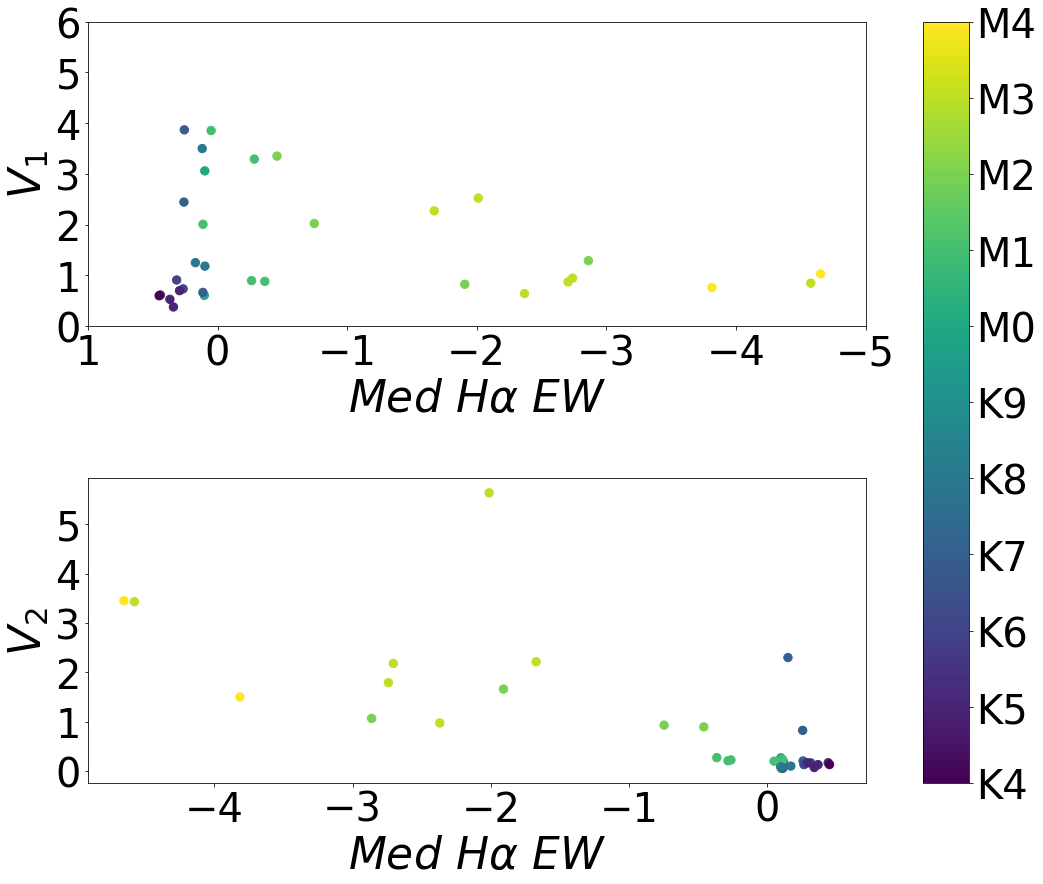

In [115]:

fig, axes = plt.subplots(nrows=2, figsize=(16,14))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.scatter(med_EW, vary_stat1, s = 70, c = spec_plot)
ax1.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
ax1.set_ylim(0,6)
#ax1.set_xticks(fontsize = 40)
#ax1.set_yticks(fontsize = 40)
ax1.set_xlim(1,-5)
ax2.scatter(med_EW, vary_stat2, s = 70, c = spec_plot)
ax2.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax2.set_ylabel(r'$V_2$', fontsize = 44)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
#ax2.set_ylim(-2,6)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)


cbar_ax1 = fig.add_axes([0.85, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax1)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.5, right=0.8)


plt.savefig('/Users/amandaash/Desktop/varivactivity.pdf')
plt.show()

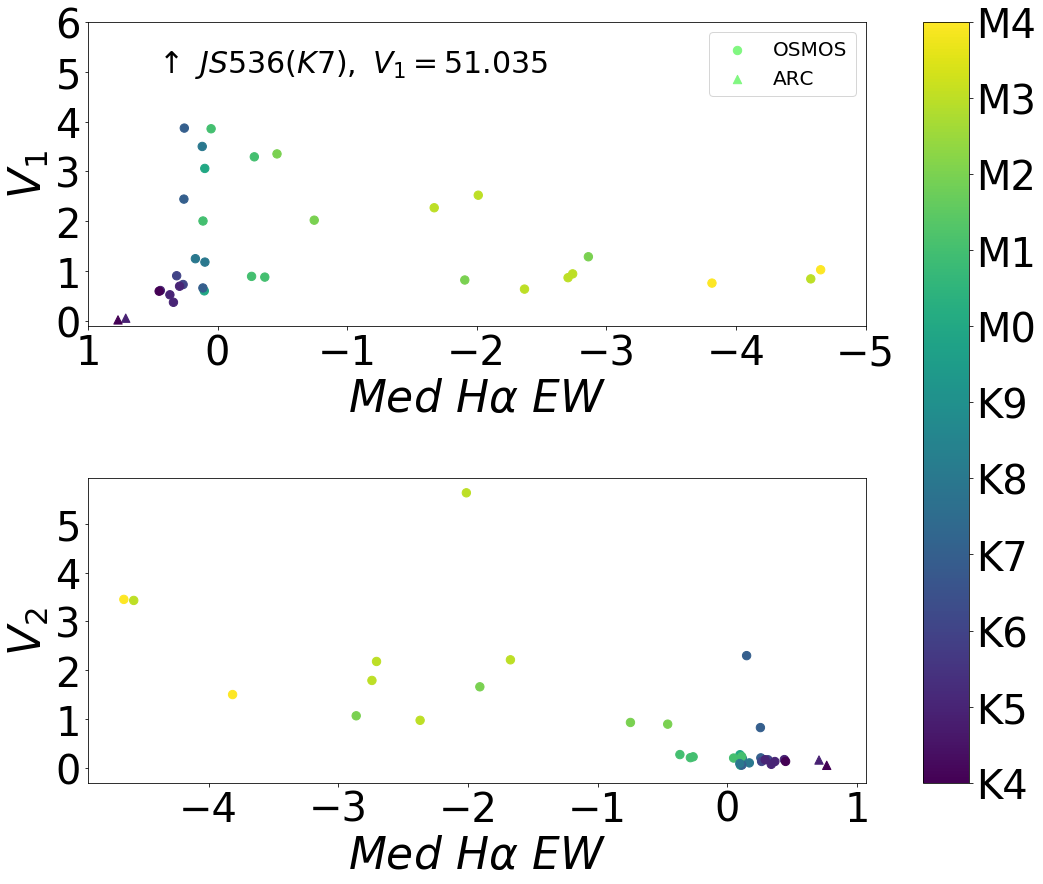

In [116]:
fig, axes = plt.subplots(nrows=2, figsize=(16,14))

ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

ax1.scatter(med_EW, vary_stat1, s = 70, c = spec_plot, label = 'OSMOS')
ax1.scatter(morris_med_EW, v1_morris, s = 70, c = spec_plot_morris, cmap = cmap_ARC, marker = '^', label = 'ARC' )
ax1.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax1.set_ylabel(r'$V_1$', fontsize = 44)
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
ax1.set_ylim(-0.1,6)
#ax1.set_xticks(fontsize = 40)
#ax1.set_yticks(fontsize = 40)
ax1.set_xlim(1,-5)
ax1.legend(prop={'size': 20})
ax1.text(0.5,5,r'$\uparrow \ JS536(K7), \ V_1=51.035$', fontsize = 30)


ax2.scatter(med_EW, vary_stat2, s = 70, c = spec_plot, label = 'OSMOS')
ax2.scatter(morris_med_EW, v2_morris, s = 70, c = spec_plot_morris, cmap = cmap_ARC, marker = '^', label = 'ARC' )
ax2.set_xlabel(r'$Med \ H \alpha \ EW$', fontsize = 44)
ax2.set_ylabel(r'$V_2$', fontsize = 44)
for tick in ax2.xaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in ax2.yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
#ax2.set_ylim(-2,6)

fig.subplots_adjust(wspace=0.1, hspace=0.1, right=0.8)


cbar_ax1 = fig.add_axes([0.85, 0.125, 0.04, 0.755])
cbar = plt.colorbar(sv1, ticks = [1,2,3,4,5,6,7,8,9,10,11], cax=cbar_ax1)
cbar.ax.set_yticklabels(['K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'M0', 'M1', 'M2', 'M3', 'M4'], fontsize = 40)

fig.subplots_adjust(wspace=0.1, hspace=0.5, right=0.8)
plt.savefig('/Users/amandaash/Desktop/varivactivity_OSMOS_ARC.pdf')
plt.show()